In [ ]:
!pip install lightgbm
!pip install xgboost
!pip install plotly
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm
import warnings
import lightgbm as lgb
# from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from lightgbm import plot_importance,plot_tree,create_tree_digraph
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [ ]:
energy = pd.read_csv('energy_dataset.csv')
energy.head(5)

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [ ]:
weather = pd.read_csv('weather_features.csv')
weather.head(5)

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0         0.0   
1        77           1        62      0.0      0.0      0.0         0.0   
2        78           0        23      0.0      0.0      0.0         0.0   
3        78           0        23      0.0      0.0      0.0         0.0   
4        78           0        23      0.0      0.0      0.0         0.0   

   weather_id weather_main weather_description weather_icon  
0       800.0        clear        sky is clear          01n  
1       800.0        clear        sky is clear          01n  
2       800.0        clear        sky is clear          01n  
3       800.0        clear        sky is clear          01n  
4       800.0        clear        sky is clear          01n

**Explore weather dataset:**

In [ ]:
print(weather.shape)

(37369, 17)


In [ ]:
print(weather.dt_iso.min(), weather.dt_iso.max())

2015-01-01 00:00:00+01:00 2018-12-31 23:00:00+01:00


In [ ]:
print(weather["city_name"].value_counts())

city_name
Valencia    35145
Madrid       2224
Name: count, dtype: int64


In [ ]:
print(weather["weather_main"].value_counts())
print(weather["weather_icon"].value_counts())
print(weather["weather_description"].value_counts())


weather_main
clouds          18094
clear           16689
rain             2114
mist              190
thunderstorm      169
drizzle            58
fog                45
smoke               6
haze                3
Name: count, dtype: int64
weather_icon
01n    8201
02d    6781
01d    6015
02n    4068
01     1717
03d    1678
04d    1607
04n    1532
03n    1385
02      947
10      768
10n     654
10d     582
03      462
04      390
50n     184
11d      96
09n      90
09d      78
11n      73
50d      60
Name: count, dtype: int64
weather_description
sky is clear                    16689
few clouds                      11040
scattered clouds                 3525
broken clouds                    3026
light rain                       1381
overcast clouds                   503
moderate rain                     490
mist                              190
heavy intensity rain              127
light intensity shower rain        66
thunderstorm                       60
light intensity drizzle           

In [ ]:
weather_count=weather.isnull().sum()
weather_count

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                1
snow_3h                1
clouds_all             1
weather_id             1
weather_main           1
weather_description    1
weather_icon           1
dtype: int64

**Drop duplicates and rename column in weather data:**

In [ ]:
weather = weather.drop_duplicates(subset="dt_iso", keep="first")
weather = weather.rename({"dt_iso": "time"}, axis=1)

In [ ]:
weather

time city_name     temp  temp_min  temp_max  \
0      2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475   
1      2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475   
2      2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686   
3      2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686   
4      2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686   
...                          ...       ...      ...       ...       ...   
35140  2018-12-31 19:00:00+01:00  Valencia  285.640   285.150   286.150   
35141  2018-12-31 20:00:00+01:00  Valencia  283.140   282.150   284.150   
35142  2018-12-31 21:00:00+01:00  Valencia  281.660   281.150   282.150   
35143  2018-12-31 22:00:00+01:00  Valencia  280.140   279.150   281.150   
35144  2018-12-31 23:00:00+01:00  Valencia  279.140   278.150   280.150   

       pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
0          1001        77           1        62      0.0      0.0      0.0   
1          1001        77           1        62      0.0      0.0      0.0   
2          1002        78           0        23      0.0      0.0      0.0   
3          1002        78           0        23      0.0      0.0      0.0   
4          1002        78           0        23      0.0      0.0      0.0   
...         ...       ...         ...       ...      ...      ...      ...   
35140      1028        62           2       140      0.0      0.0      0.0   
35141      1029        71           1       242      0.0      0.0      0.0   
35142      1029        81           3       300      0.0      0.0      0.0   
35143      1029        81           2       310      0.0      0.0      0.0   
35144      1029        75           2       300      0.0      0.0      0.0   

       clouds_all  weather_id weather_main weather_description weather_icon  
0             0.0       800.0        clear        sky is clear          01n  
1             0.0       800.0        clear        sky is clear          01n  
2             0.0       800.0        clear        sky is clear          01n  
3             0.0       800.0        clear        sky is clear          01n  
4             0.0       800.0        clear        sky is clear          01n  
...           ...         ...          ...                 ...          ...  
35140         0.0       800.0        clear        sky is clear          01n  
35141         0.0       800.0        clear        sky is clear          01n  
35142         0.0       800.0        clear        sky is clear          01n  
35143         0.0       800.0        clear        sky is clear          01n  
35144         0.0       800.0        clear        sky is clear          01n  

[35064 rows x 17 columns]

** Explore energy data : **

In [ ]:
print(energy.shape)

(35064, 29)


In [ ]:
print(energy.time.min(), energy.time.max())

2015-01-01 00:00:00+01:00 2018-12-31 23:00:00+01:00


In [ ]:
energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       generation waste  generation wind offshore  generation wind onshore  \
count      35045.000000                   35046.0             35046.000000   
mean         269.452133                       0.0              5464.479769   
std           50.195536                       0.0              3213.691587   
min            0.000000                       0.0                 0.000000   
25%          240.000000                       0.0              2933.000000   
50%          279.000000                       0.0              4849.000000   
75%          310.000000                       0.0              7398.000000   
max          357.000000                       0.0             17436.000000   

       forecast solar day ahead  forecast wind offshore eday ahead  \
count              35064.000000                                0.0   
mean                1439.066735                                NaN   
std                 1677.703355       

In [ ]:
energy_count=energy.isnull().sum()
energy_count

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [ ]:
energy.drop(
    [
        "generation fossil coal-derived gas",
        "generation fossil oil shale",
        "generation fossil peat",
        "generation geothermal",
        "generation marine",
        "generation wind offshore",
        "generation hydro pumped storage aggregated",
        "forecast wind offshore eday ahead",
    ],
    axis=1,
    inplace=True,
)


In [ ]:
energy.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [ ]:
energy.shape

(35064, 21)

### ***Merging the energy and weather Datasets on Time :***

In [ ]:
full_df = pd.merge(energy, weather, on='time')
full_df

time  generation biomass  \
0      2015-01-01 00:00:00+01:00               447.0   
1      2015-01-01 01:00:00+01:00               449.0   
2      2015-01-01 02:00:00+01:00               448.0   
3      2015-01-01 03:00:00+01:00               438.0   
4      2015-01-01 04:00:00+01:00               428.0   
...                          ...                 ...   
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  generation fossil gas  \
0                                     329.0                 4844.0   
1                                     328.0                 5196.0   
2                                     323.0                 4857.0   
3                                     254.0                 4314.0   
4                                     187.0                 4130.0   
...                                     ...                    ...   
35059                                   0.0                 7634.0   
35060                                   0.0                 7241.0   
35061                                   0.0                 7025.0   
35062                                   0.0                 6562.0   
35063                                   0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
0                           4821.0                  162.0   
1                           4755.0                  158.0   
2                           4581.0                  157.0   
3                           4131.0                  160.0   
4                           3840.0                  156.0   
...                            ...                    ...   
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation hydro pumped storage consumption  \
0                                            863.0   
1                                            920.0   
2                                           1164.0   
3                                           1503.0   
4                                           1826.0   
...                                            ...   
35059                                          1.0   
35060                                          1.0   
35061                                         50.0   
35062                                        108.0   
35063                                        108.0   

       generation hydro run-of-river and poundage  \
0                                          1051.0   
1                                          1009.0   
2                                           973.0   
3                                           949.0   
4                                           953.0   
...                                           ...   
35059                                      1135.0   
35060                                      1172.0   
35061                                      1148.0   
35062                                      1128.0   
35063                                      1069.0   

       generation hydro water reservoir  generation nuclear  ...  wind_speed  \
0                                1899.0              7096.0  ...           1   
1                                1658.0              7096.0  ...           1   
2                                1371.0              7099.0  ...           0   
3                                 779.0              7098.0  ...           0   
4                                 720.0              7097.0  ...           0   
...            

**Numerical distribution for data cleaning:**

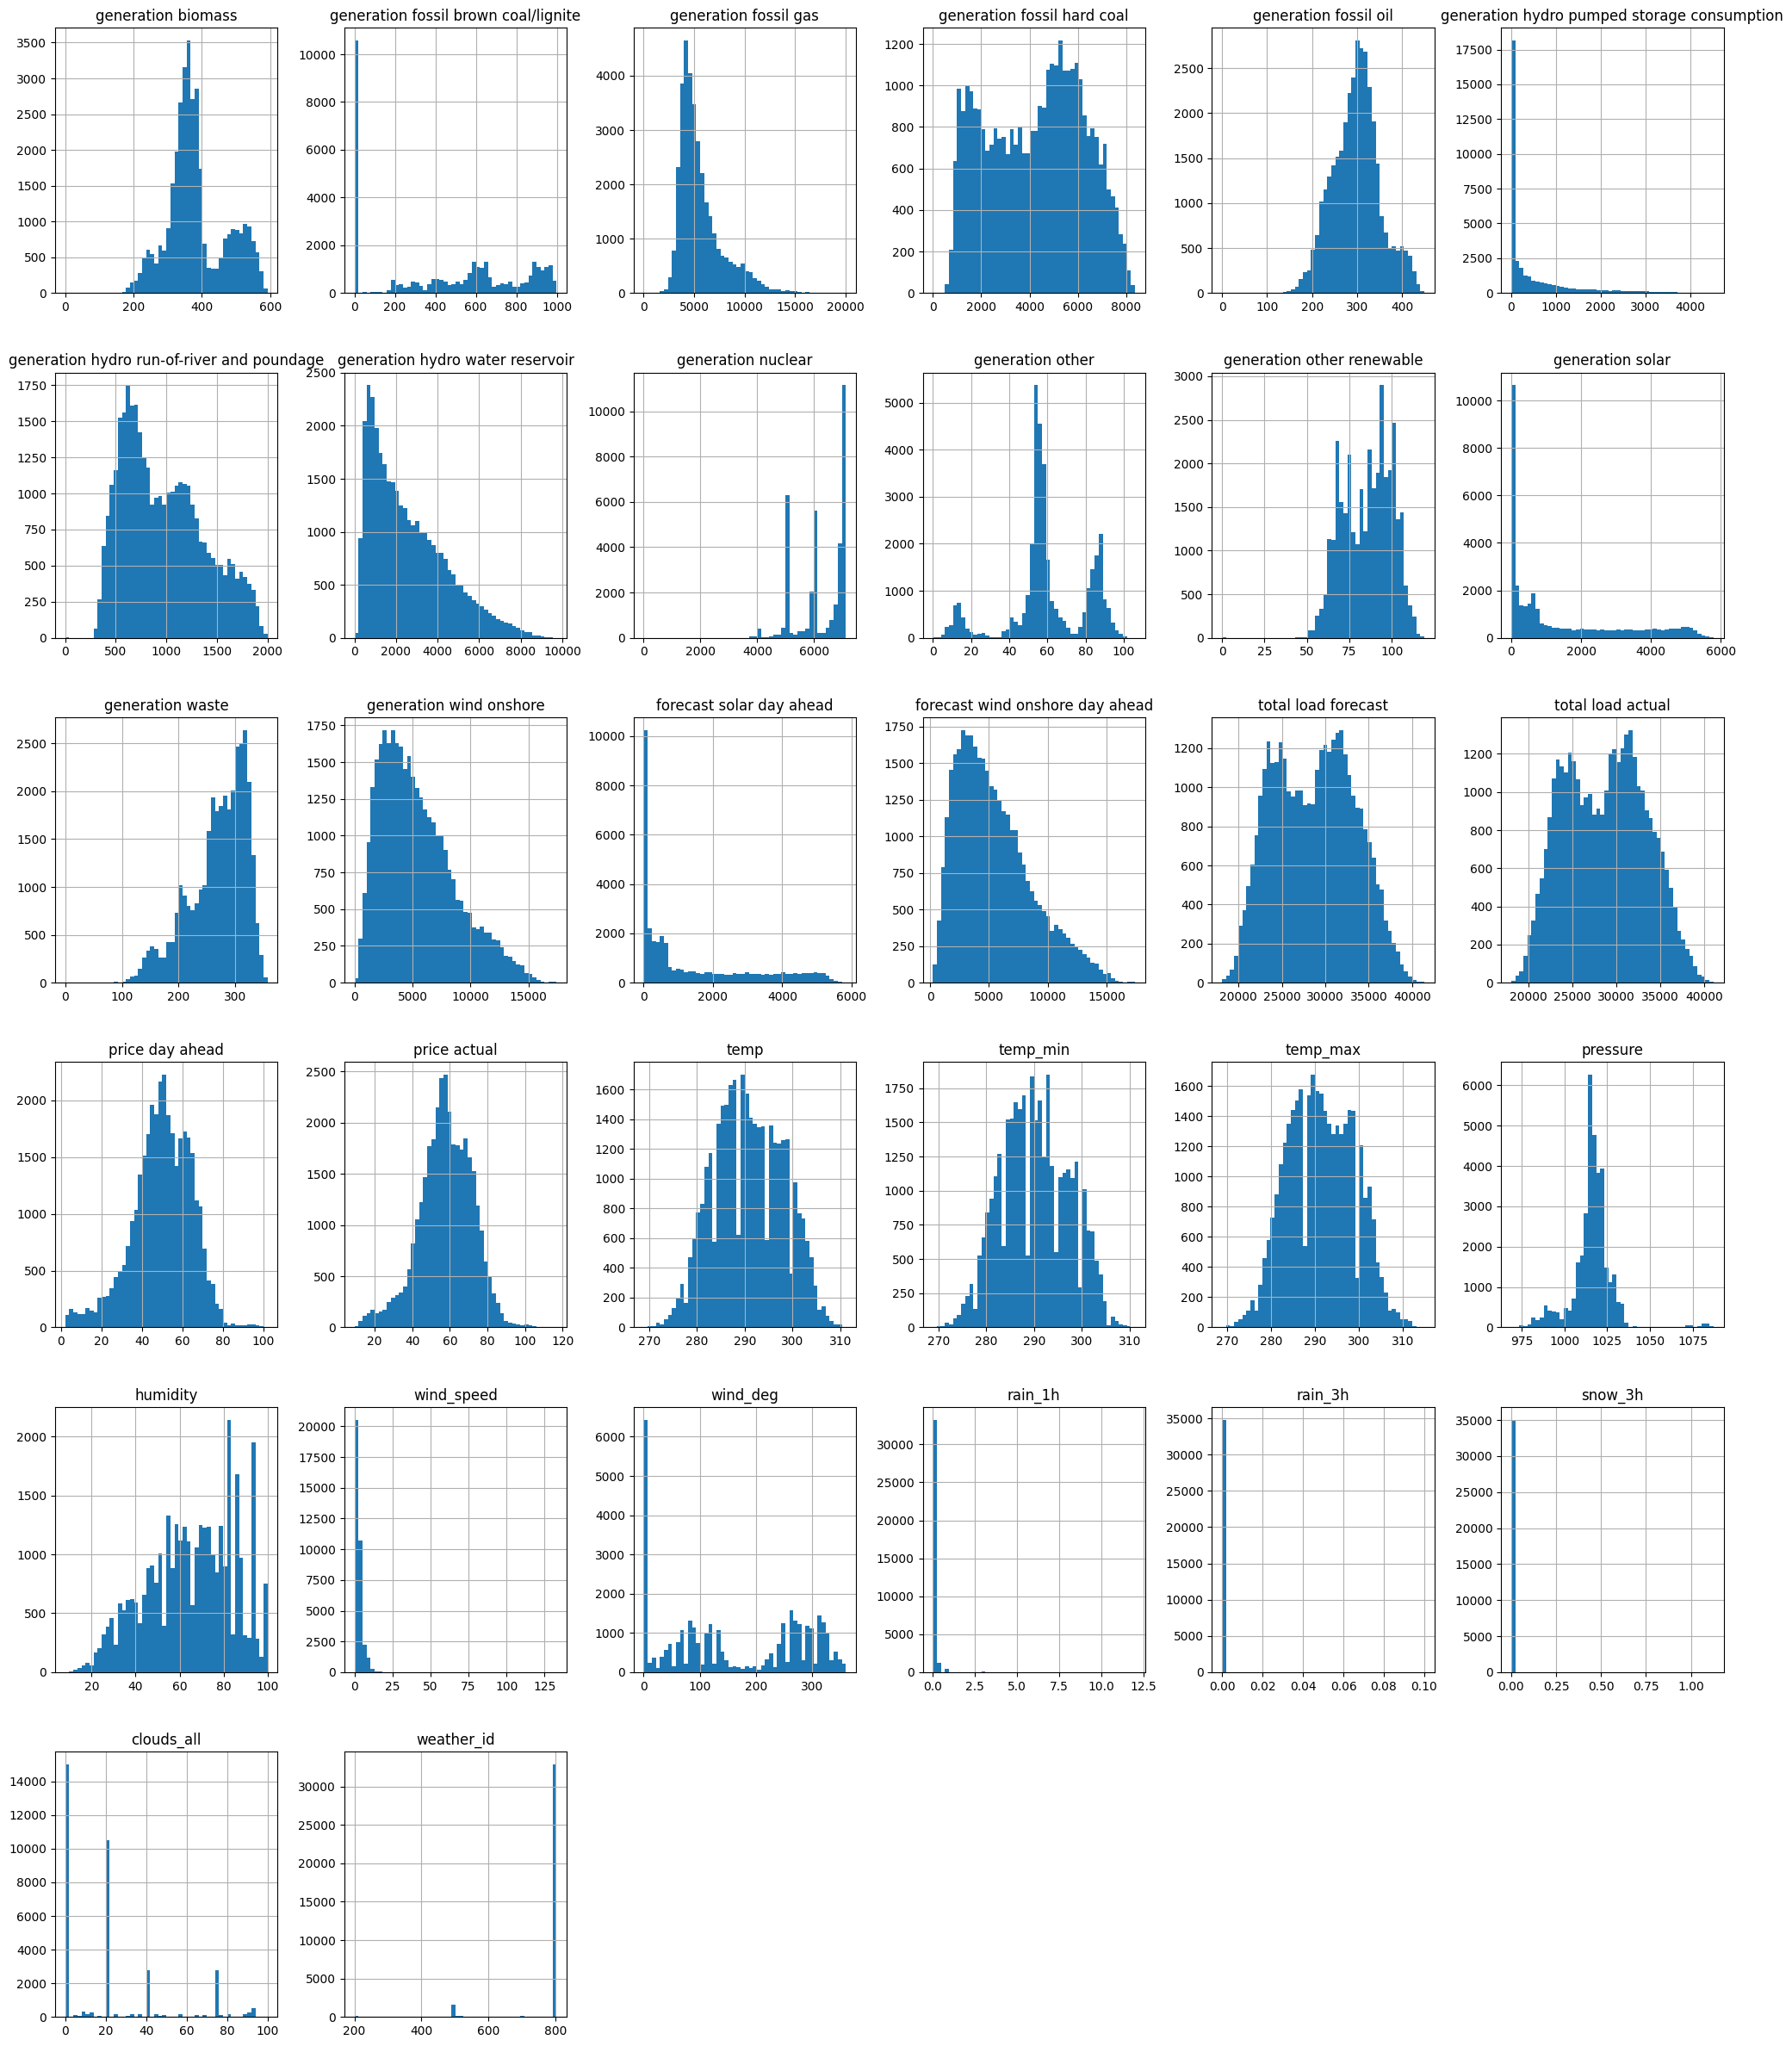

<Figure size 640x480 with 0 Axes>

In [ ]:
full_df.hist(figsize=(25, 30), bins=50, xlabelsize=10, ylabelsize=10)
plt.show()
# Save the figure
plt.savefig('full_df_histograms.png')
plt.show()

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [ ]:
full_df.drop(columns=['city_name','snow_3h', 'rain_3h','temp_max','temp_min','weather_main','weather_id','generation hydro pumped storage consumption','forecast solar day ahead','forecast wind onshore day ahead','total load forecast','wind_deg','clouds_all','weather_icon','weather_description','price day ahead'],inplace=True)

** Feature Engineering : **


In [ ]:
full_df['time'] = pd.to_datetime(full_df['time'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')
full_df.set_index('time', inplace=True)


In [ ]:
def extract_from_date(data):
    data.index = pd.to_datetime(data.index, errors='coerce')

    data["year"] = data.index.year
    data["month"] = data.index.month
    data["hour"] = data.index.hour
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day

    return data

full_df = extract_from_date(full_df)
full_df.reset_index(inplace=True)
full_df.drop(columns=['time'], inplace=True)


**Handling Missing Values:**

In [ ]:
full_df.dropna(inplace=True)

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14374 entries, 0 to 35063
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   generation biomass                          14374 non-null  float64
 1   generation fossil brown coal/lignite        14374 non-null  float64
 2   generation fossil gas                       14374 non-null  float64
 3   generation fossil hard coal                 14374 non-null  float64
 4   generation fossil oil                       14374 non-null  float64
 5   generation hydro run-of-river and poundage  14374 non-null  float64
 6   generation hydro water reservoir            14374 non-null  float64
 7   generation nuclear                          14374 non-null  float64
 8   generation other                            14374 non-null  float64
 9   generation other renewable                  14374 non-null  float64
 10  generation sola

# **Time Series Splitting :**

In [ ]:
split_date = pd.Timestamp('2018-12-01')
train = full_df.loc[~((full_df["year"] == 2018) & (full_df["month"] == 12))]
test = full_df.loc[(full_df["year"] == 2018) & (full_df["month"] == 12)]

In [ ]:
full_df['temp'] = full_df['temp'] - 273.15

**Boxplot to detect the Outliers:**

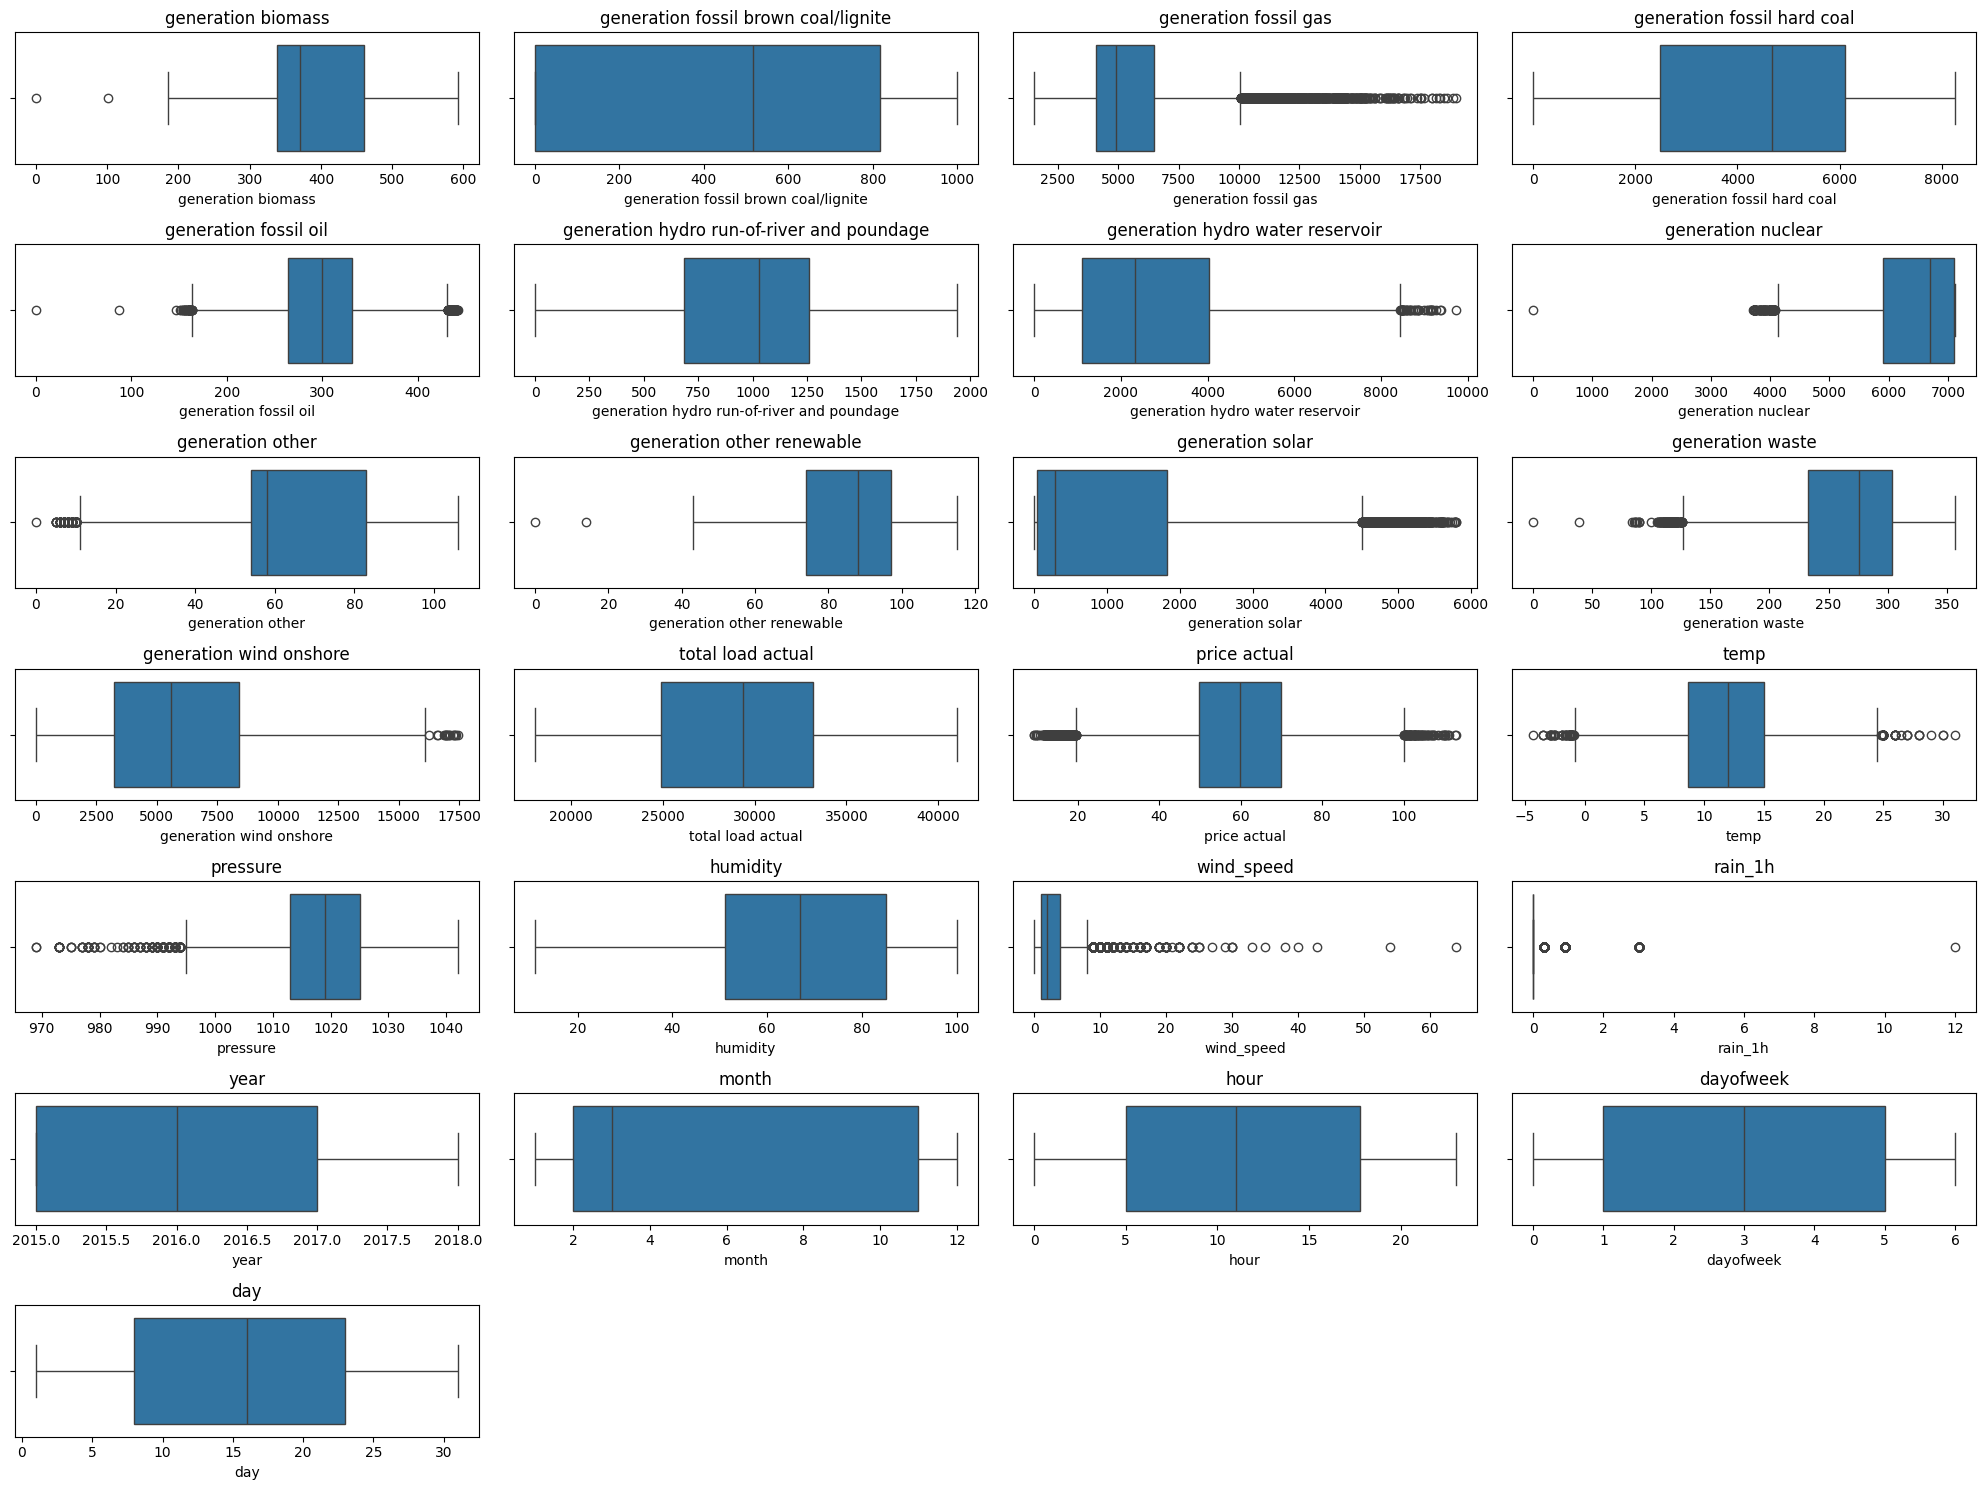

In [ ]:
n_cols = 4
n_rows = int(np.ceil(len(full_df.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(full_df.columns):
    sns.boxplot(data=full_df[col], orient='h', ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Outlier Detection & Capping:**

In [ ]:
for col in full_df.columns:
    z = np.abs(stats.zscore(full_df[col]))
    threshold = 3

    potential_outliers = full_df[(z > threshold)][col]
    print(f"\nPotential outliers in '{col}':\n", potential_outliers)

    upper_limit = np.percentile(full_df[col], 99)
    lower_limit = np.percentile(full_df[col], 1)
    full_df[col] = np.where(
        full_df[col] > upper_limit,
        upper_limit,
        np.where(
            full_df[col] < lower_limit,
            lower_limit,
            full_df[col]
        )
    )

    outliers_after_capping = full_df[(z > threshold)][col]
    print(f"\nOutliers in '{col}' after capping:\n", outliers_after_capping)


Potential outliers in 'generation biomass':
 2025     101.0
25125      0.0
Name: generation biomass, dtype: float64

Outliers in 'generation biomass' after capping:
 2025     228.0
25125    228.0
Name: generation biomass, dtype: float64

Potential outliers in 'generation fossil brown coal/lignite':
 Series([], Name: generation fossil brown coal/lignite, dtype: float64)

Outliers in 'generation fossil brown coal/lignite' after capping:
 Series([], Name: generation fossil brown coal/lignite, dtype: float64)

Potential outliers in 'generation fossil gas':
 9041     12922.0
9042     13129.0
9043     13219.0
9044     13444.0
9045     13313.0
          ...   
34053    12961.0
34962    13155.0
34963    13292.0
34964    13280.0
34965    13091.0
Name: generation fossil gas, Length: 266, dtype: float64

Outliers in 'generation fossil gas' after capping:
 9041     12922.0
9042     13129.0
9043     13219.0
9044     13444.0
9045     13313.0
          ...   
34053    12961.0
34962    13155.0
34963 

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14374 entries, 0 to 35063
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   generation biomass                          14374 non-null  float64
 1   generation fossil brown coal/lignite        14374 non-null  float64
 2   generation fossil gas                       14374 non-null  float64
 3   generation fossil hard coal                 14374 non-null  float64
 4   generation fossil oil                       14374 non-null  float64
 5   generation hydro run-of-river and poundage  14374 non-null  float64
 6   generation hydro water reservoir            14374 non-null  float64
 7   generation nuclear                          14374 non-null  float64
 8   generation other                            14374 non-null  float64
 9   generation other renewable                  14374 non-null  float64
 10  generation sola

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14374 entries, 0 to 35063
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   generation biomass                          14374 non-null  float64
 1   generation fossil brown coal/lignite        14374 non-null  float64
 2   generation fossil gas                       14374 non-null  float64
 3   generation fossil hard coal                 14374 non-null  float64
 4   generation fossil oil                       14374 non-null  float64
 5   generation hydro run-of-river and poundage  14374 non-null  float64
 6   generation hydro water reservoir            14374 non-null  float64
 7   generation nuclear                          14374 non-null  float64
 8   generation other                            14374 non-null  float64
 9   generation other renewable                  14374 non-null  float64
 10  generation sola


# ***Exploratory Data Analysis (EDA):***

In [ ]:
#Reset index before plotting
train_reset = train.reset_index()

**Correlation Matrix (Absolute Values):**

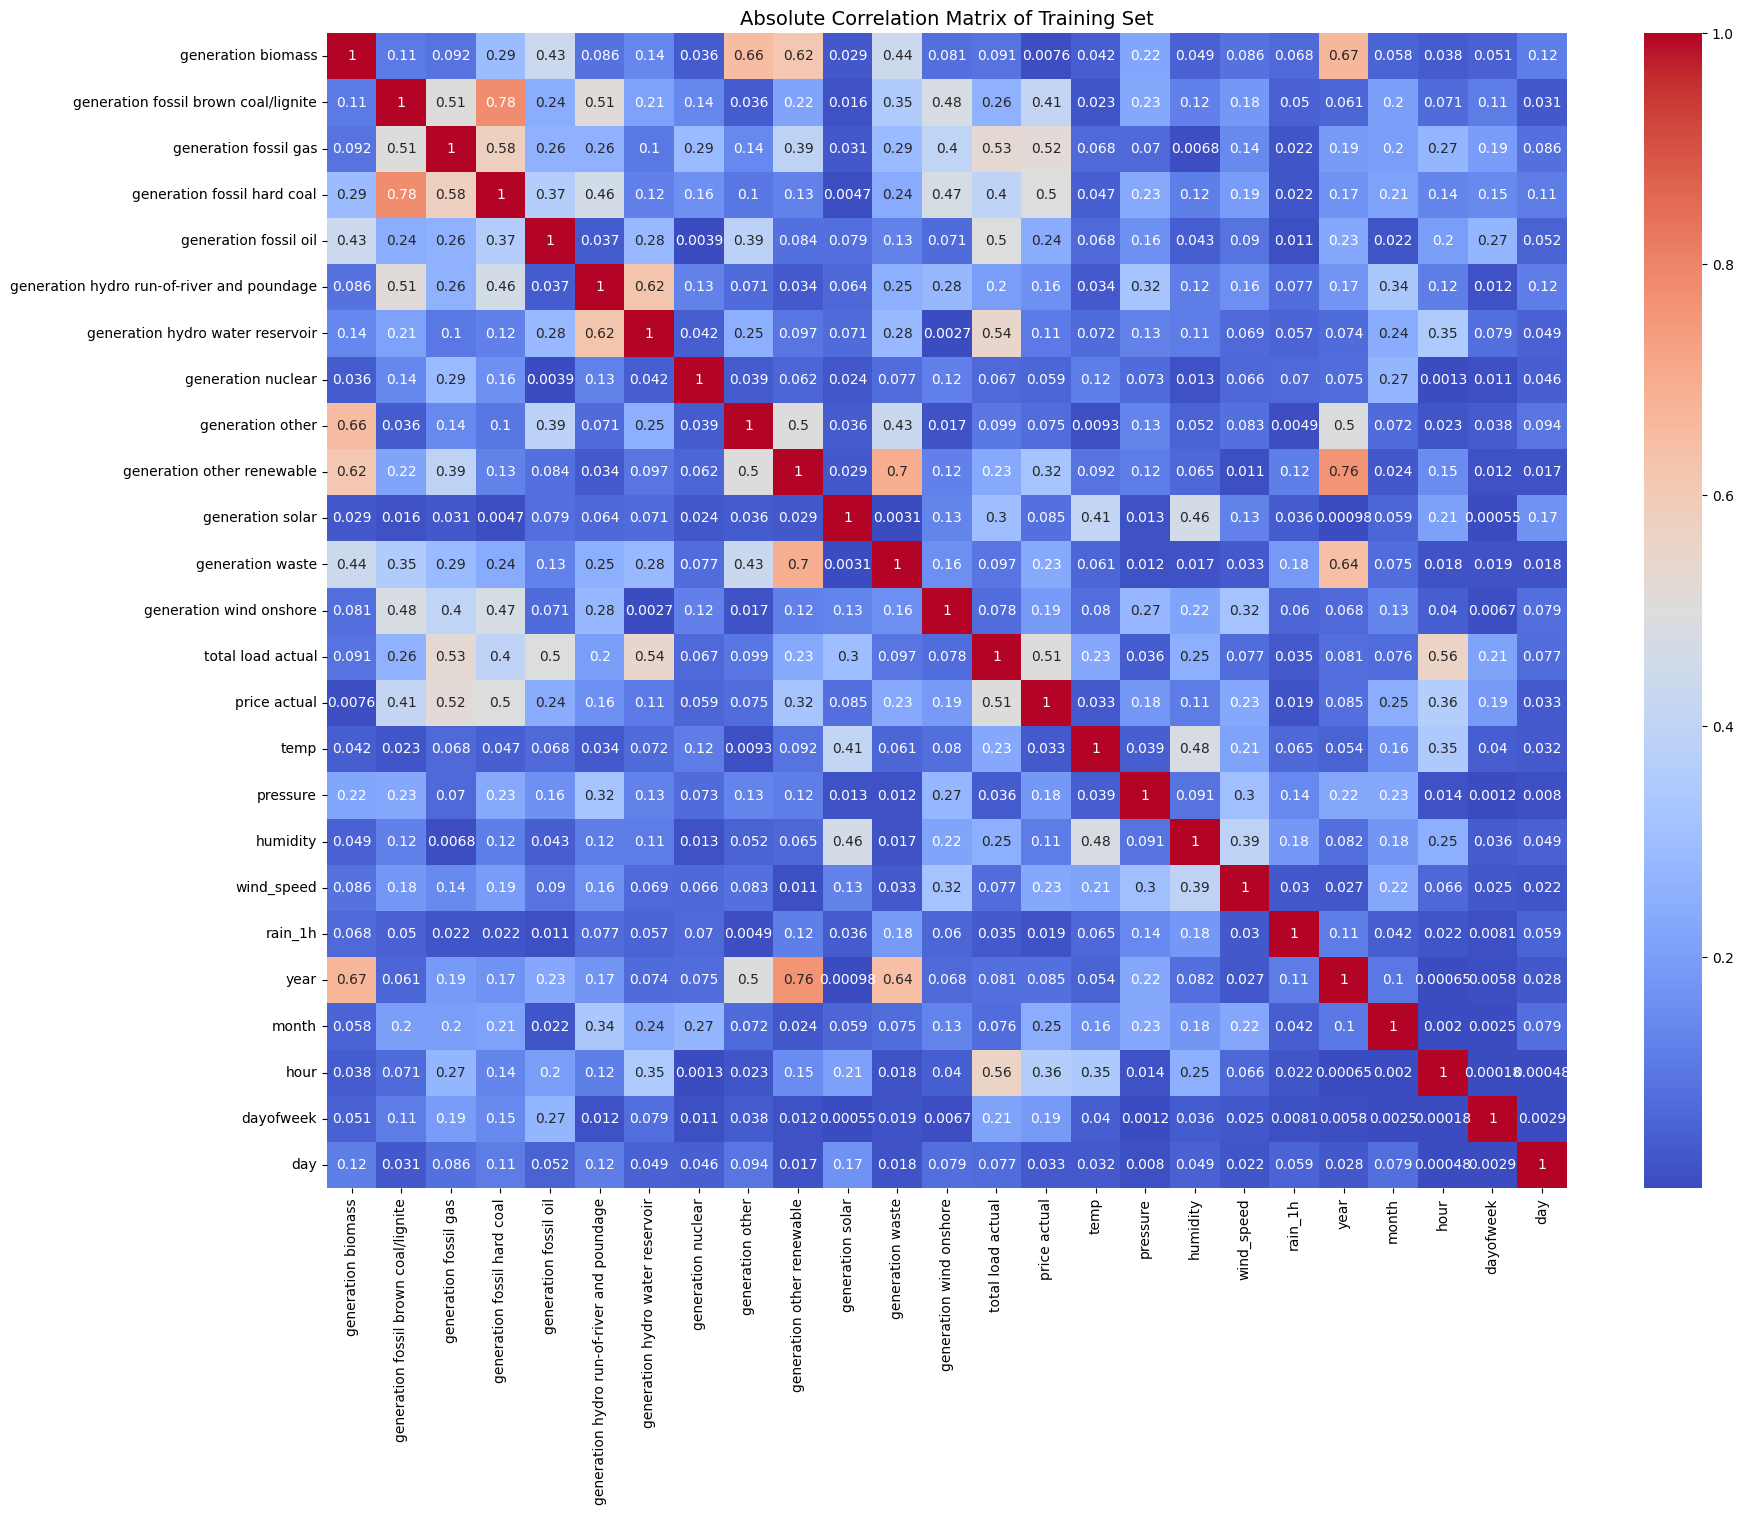

In [ ]:
correlation_matrix = train.corr().abs()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Absolute Correlation Matrix of Training Set', fontsize=14)
plt.show()

In [ ]:
correlations_with_price_actual = correlation_matrix["price actual"].sort_values(ascending=False)
top_10_correlated_features = correlations_with_price_actual.head(10)

In [ ]:
print("Top 10 Correlated Features with 'price actual':")
print(top_10_correlated_features.to_markdown(numalign="left", stralign="left"))

Top 10 Correlated Features with 'price actual':
|                                      | price actual   |
|:-------------------------------------|:---------------|
| price actual                         | 1              |
| generation fossil gas                | 0.518866       |
| total load actual                    | 0.507755       |
| generation fossil hard coal          | 0.499683       |
| generation fossil brown coal/lignite | 0.413686       |
| hour                                 | 0.364653       |
| generation other renewable           | 0.321939       |
| month                                | 0.245701       |
| generation fossil oil                | 0.238878       |
| generation waste                     | 0.232643       |


**Data Visualization (Training Set):**

In [ ]:
generation_cols = [col for col in full_df.columns if col.startswith('generation')]

**1. Donut Chart of Total Generation:**


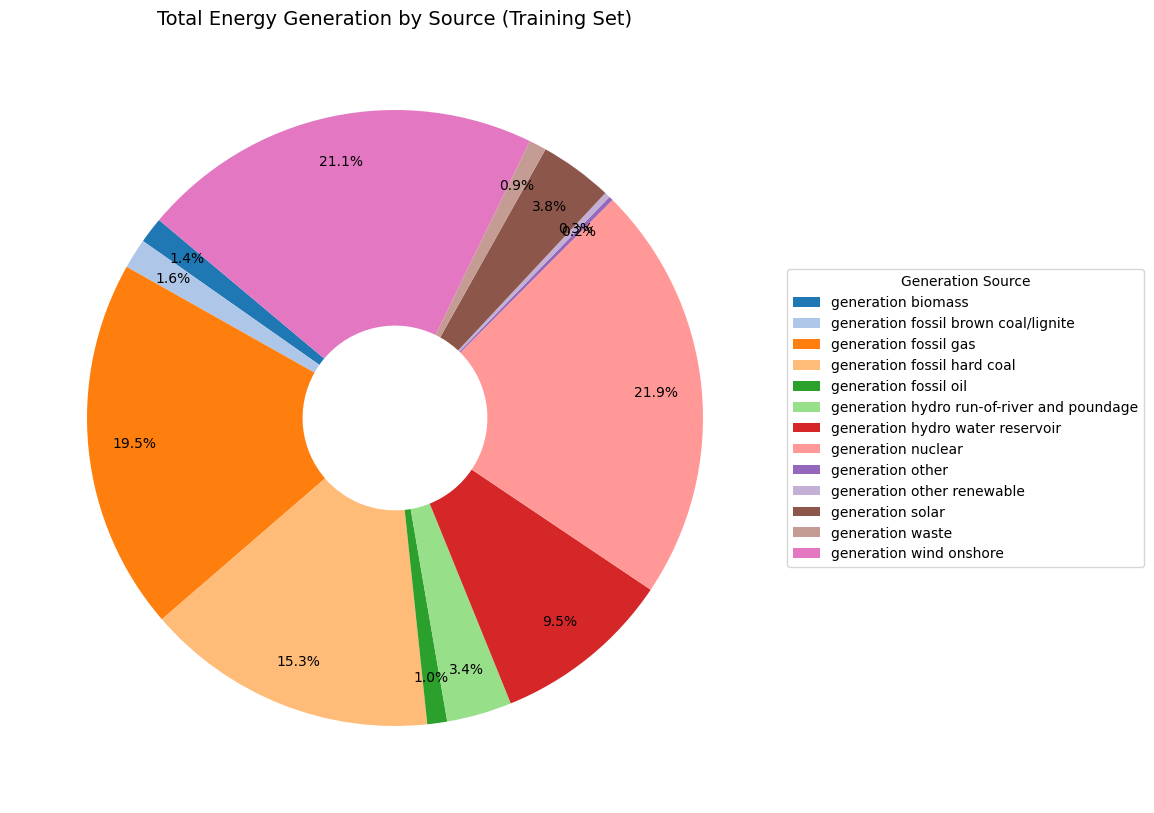

In [ ]:
import matplotlib.cm as cm

total_generation = train[generation_cols].sum(axis=0)
pie_data = pd.DataFrame({'Generation Source': total_generation.index, 'Total Generation': total_generation.values})
pie_data['Percentage'] = pie_data['Total Generation'] / pie_data['Total Generation'].sum()

colors = cm.tab20(np.arange(len(generation_cols)))
plt.figure(figsize=(10, 10))
plt.pie(pie_data['Total Generation'], autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=colors,
        wedgeprops=dict(width=0.7))

plt.legend(pie_data['Generation Source'], title="Generation Source", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Total Energy Generation by Source (Training Set)', fontsize=14)
plt.show()

:***2. Line Plots of Energy Generation Over Time (Training Set):***
#        




  ***time series of energy *generation:****

In [ ]:
for col in generation_cols:
    fig = px.line(train_reset, x='index', y=col, title=f'{col}/MWh Over Time (Training Set)')
    fig.update_xaxes(
        tickangle=-45,
        title_text='Time'
        )
    fig.update_yaxes(
        title_text=col
    )
    fig.show()
    # x-axis represents the timestamp.  per hour

In [ ]:
generation_cols = [col for col in train_reset.columns if col != 'index']  # Get all columns except 'index'

fig = px.line(train_reset, x='index', y=generation_cols, title='All Generation/MWh Over Time (Training Set)')

# Customize the x-axis
fig.update_xaxes(tickangle=-45, title_text='Time (Per Hour)')

# Add a legend
fig.update_layout(legend_title_text='Generation Source')

fig.show()

**3. Scatter Plots of Weather Impact on Energy Generation (Training Set):**

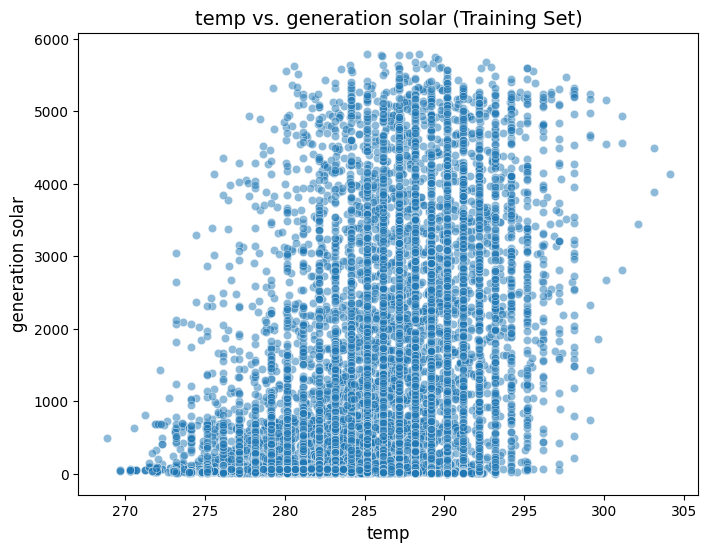

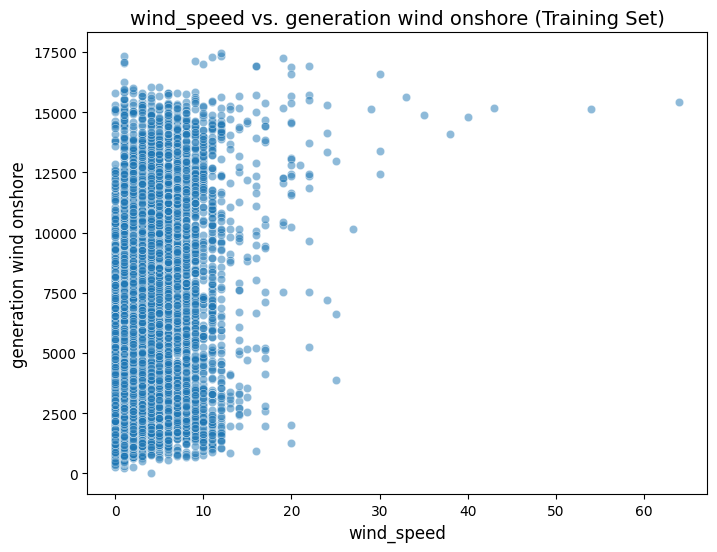

In [ ]:
scatter_pairs = [
    ('temp', 'generation solar'),
    ('wind_speed', 'generation wind onshore'),
]
for weather_col, generation_col in scatter_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=train_reset, x=weather_col, y=generation_col, alpha=0.5)
    plt.title(f'{weather_col} vs. {generation_col} (Training Set)', fontsize=14)
    plt.xlabel(weather_col, fontsize=12)
    plt.ylabel(generation_col, fontsize=12)

    plt.show()

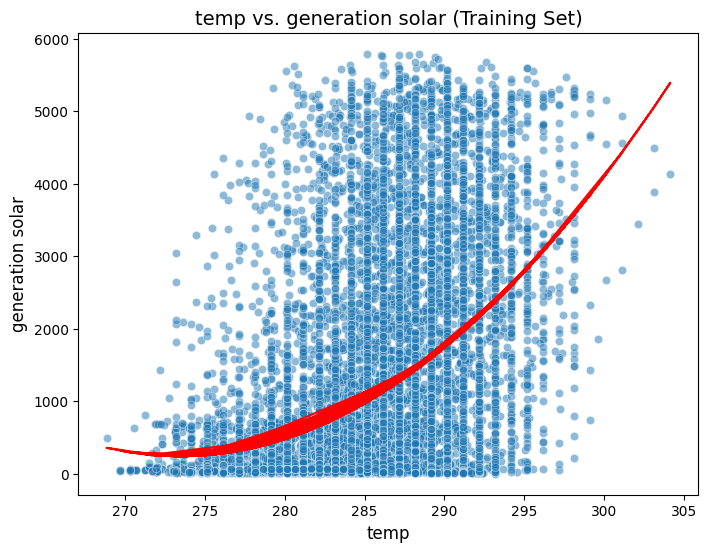

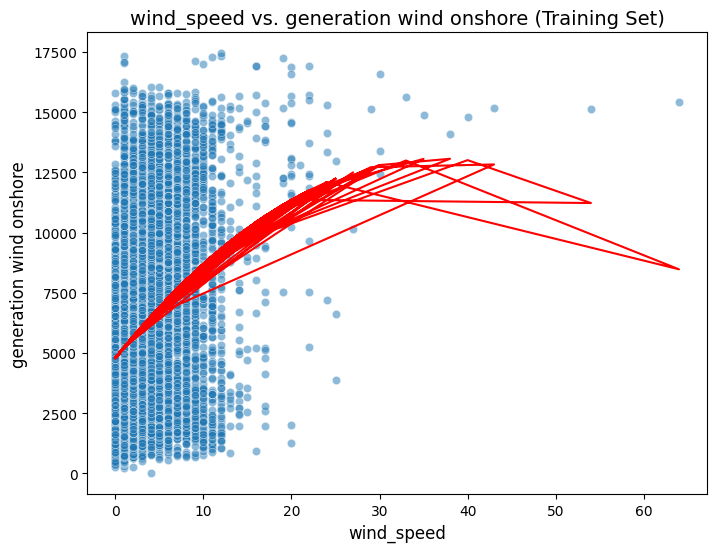

In [ ]:
import numpy as np

for weather_col, generation_col in scatter_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=train_reset, x=weather_col, y=generation_col, alpha=0.5)

    # Fit polynomial (adjust degree as needed)
    x = train_reset[weather_col]
    y = train_reset[generation_col]
    z = np.polyfit(x, y, deg=2)  # Quadratic fit, try deg=3 for cubic, etc.
    p = np.poly1d(z)

    # Plot curve
    plt.plot(x, p(x), color='red')

    plt.title(f'{weather_col} vs. {generation_col} (Training Set)', fontsize=14)
    plt.xlabel(weather_col, fontsize=12)
    plt.ylabel(generation_col, fontsize=12)
    plt.show()


## ***Time Series Analysis:***

In [ ]:
# Reconstruct datetime and set as index
# full_df['time'] = pd.to_datetime(full_df[['year', 'month', 'day', 'hour']])
# full_df.set_index('time', inplace=True)

# Check for gaps in the data
# print("Start:", full_df.index.min(), "End:", full_df.index.max())

# Check for duplicates
# print("Duplicate indices:", full_df.index.duplicated().sum())

# Resample data to ensure hourly frequency
# full_df = full_df.resample('H').mean()
# full_df.index.freq = 'H'

# Verify frequency
# print(full_df.index.freq)


In [ ]:
target_column = 'price actual'

In [ ]:
full_df[f'{target_column}_diff'] = full_df[target_column].diff(1)
full_df[f'{target_column}_diff'].fillna(0, inplace=True)

Time Series Visualization for "price actual" :


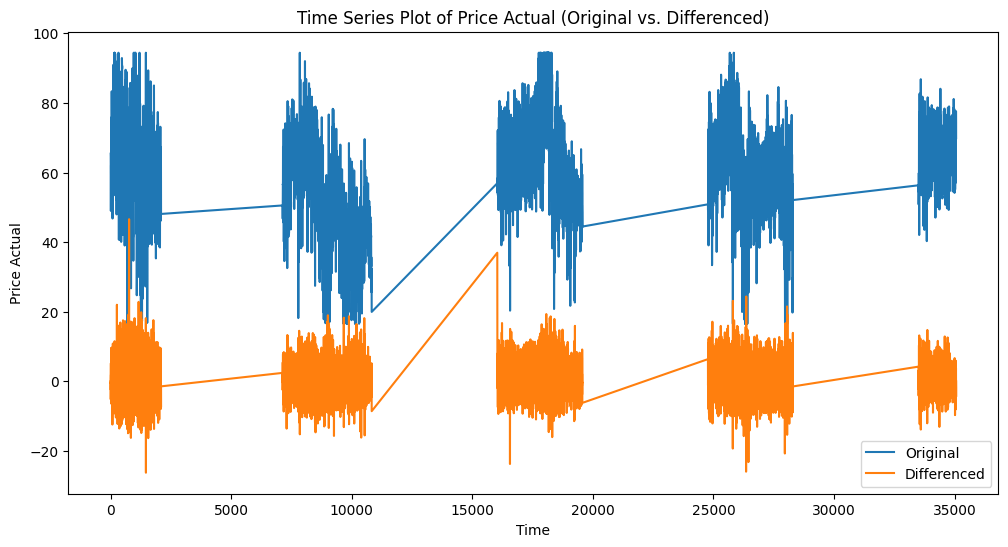

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(full_df.index, full_df['price actual'], label='Original')
plt.plot(full_df.index, full_df[f'{target_column}_diff'], label='Differenced')
plt.title('Time Series Plot of Price Actual (Original vs. Differenced)')
plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.legend()
plt.show()

In [ ]:
result = seasonal_decompose(full_df[f'{target_column}_diff'], model='additive', period=24)

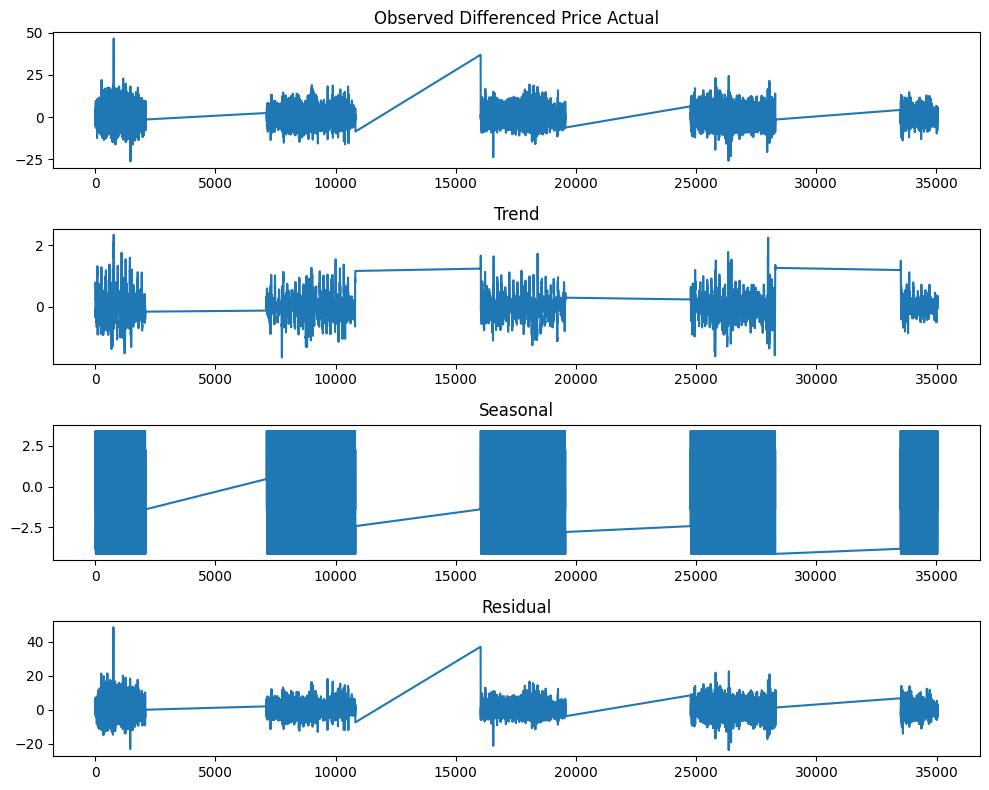

In [ ]:
# Plot decomposition components
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=axes[0], title='Observed Differenced Price Actual')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

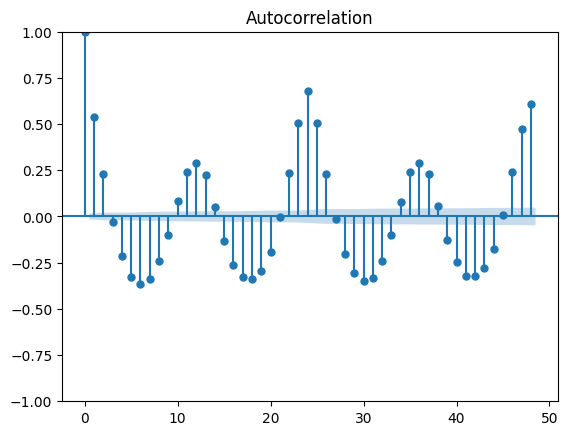

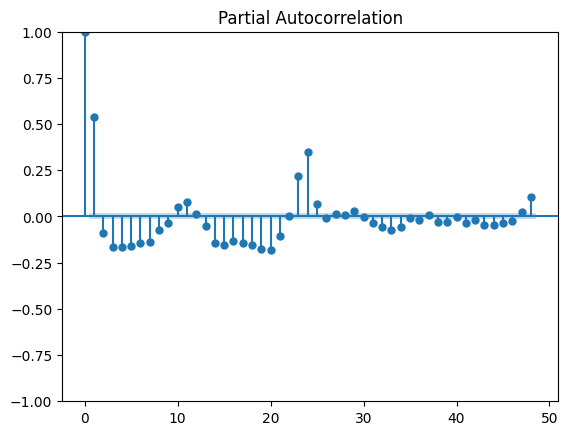

In [ ]:
# ACF and PACF plots for price_actual
plot_acf(full_df[f'{target_column}_diff'], lags=48)
plt.show()
plot_pacf(full_df[f'{target_column}_diff'], lags=48)
plt.show()


In [ ]:
# Fit ARIMA Model (using the differenced price_actual)
model = ARIMA(full_df[f'{target_column}_diff'], order=(5,1,0))  # (p,d,q)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:      price actual_diff   No. Observations:                14374
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -40359.758
Date:                Mon, 24 Jun 2024   AIC                          80731.516
Time:                        08:00:46   BIC                          80776.955
Sample:                             0   HQIC                         80746.624
                              - 14374                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2170      0.005    -42.955      0.000      -0.227      -0.207
ar.L2         -0.1375      0.007    -19.118      0.000      -0.152      -0.123
ar.L3         -0.1446      0.008    -18.185      0.0

In [ ]:
forecast = model_fit.get_forecast(steps=24, alpha=0.05)  # Include alpha for confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [ ]:
actual_values = full_df[f'{target_column}_diff'].iloc[-24:].values


In [ ]:
mae = mean_absolute_error(actual_values, forecast_mean)
mse = mean_squared_error(actual_values, forecast_mean)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')

Mean Absolute Error (MAE): 2.016
Mean Squared Error (MSE): 8.608


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14374 entries, 0 to 35063
Data columns (total 26 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   generation biomass                          14374 non-null  float64
 1   generation fossil brown coal/lignite        14374 non-null  float64
 2   generation fossil gas                       14374 non-null  float64
 3   generation fossil hard coal                 14374 non-null  float64
 4   generation fossil oil                       14374 non-null  float64
 5   generation hydro run-of-river and poundage  14374 non-null  float64
 6   generation hydro water reservoir            14374 non-null  float64
 7   generation nuclear                          14374 non-null  float64
 8   generation other                            14374 non-null  float64
 9   generation other renewable                  14374 non-null  float64
 10  generation sola

In [ ]:
full_df = full_df.drop('year', axis=1)

In [ ]:
full_df = full_df.drop(f'{target_column}_diff', axis=1)

**Splitting Data and Preparing the Target Variable**






In [ ]:
from sklearn.model_selection import train_test_split

# Create Target variable
target = 'price actual'

# Split data into feature matrix and target vector
y = full_df[target]
X = full_df.drop(columns=target)

# Split data into train / validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Additional preprocessing on the validation set
# X_val = X_val.drop(columns=['price_actual_lag1', 'price_actual_lag7', 'price_actual_rolling_mean_7', 'year'], axis=1)


In [ ]:
X_val

generation biomass  generation fossil brown coal/lignite  \
34044               351.0                                 722.0   
26268               281.0                                   0.0   
25841               351.0                                 985.0   
27874               354.0                                 658.0   
9712                379.0                                 985.0   
...                   ...                                   ...   
26028               384.0                                 982.0   
18441               358.0                                 195.0   
34132               322.0                                 610.0   
10786               495.0                                   0.0   
8039                526.0                                 931.0   

       generation fossil gas  generation fossil hard coal  \
34044                12934.0                      6128.00   
26268                 3391.0                       918.73   
25841                12145.0                      6669.00   
27874                 6539.0                      4752.00   
9712                  6969.0                      6737.00   
...                      ...                          ...   
26028                11715.0                      7645.00   
18441                 4214.0                      1712.00   
34132                 6675.0                      6148.00   
10786                 3309.0                      1172.00   
8039                  5318.0                      6807.00   

       generation fossil oil  generation hydro run-of-river and poundage  \
34044                  290.0                                      1115.0   
26268                  213.0                                      1114.0   
25841                  344.0                                      1038.0   
27874                  325.0                                      1481.0   
9712                   305.0                                       686.0   
...                      ...                                         ...   
26028                  324.0                                      1068.0   
18441                  250.0                                       716.0   
34132                  240.0                                      1022.0   
10786                  294.0                                      1463.0   
8039                   332.0                                       915.0   

       generation hydro water reservoir  generation nuclear  generation other  \
34044                            4907.0              5057.0              57.0   
26268                            1686.0              7093.0              54.0   
25841                            1398.0              7079.0              56.0   
27874                            5892.0              6008.0              64.0   
9712                             3691.0              6932.0              55.0   
...                                 ...                 ...               ...   
26028                            1928.0              7089.0              46.0   
18441                             607.0              6022.0              54.0   
34132                            1409.0              5052.0              55.0   
10786                            3518.0              7100.0              90.0   
8039                             1611.0              7103.0              81.0   

       generation other renewable  ...  total load actual    temp  pressure  \
34044                        98.0  ...            33997.0  15.000    1001.0   
26268                        84.0  ...            27936.0  20.000    1025.0   
25841                        99.0  ...            35328.0  15.000    1016.0   
27874                        94.0  ...            34577.0  12.000    1009.0   
9712                         87.0  ...            35676.0  19.050    1014.0   
...                           ...  ...                ...     ...       ...   
26028                        9

**Comparison of Regression Model Performance**
* Model Training, Evaluation, and Metrics Collection




In [ ]:
# Assigning model variables
model_lr = LinearRegression()
model_rfr = RandomForestRegressor()
model_xgbr = XGBRegressor()
model_lgbm = LGBMRegressor()

# Defining a function to check model metrics and store results in a list
model_rfr.fit(X_train, y_train)
model_xgbr.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_lgbm.fit(X_train, y_train)

# Defining a function to check model metrics and store results in a list
def check_metrics(model, model_name):
    training_mae = mean_absolute_error(y_train, model.predict(X_train))
    validation_mae = mean_absolute_error(y_val, model.predict(X_val))
    validation_r2 = model.score(X_val, y_val)

    return {
        'Model': model_name,
        'Training MAE': training_mae,
        'Validation MAE': validation_mae,
        'R2 score': validation_r2
    }

# List of models and their names
models = [
    (model_xgbr, 'XGBRegressor'),
    (model_rfr, 'RandomForestRegressor'),
    (model_lr, 'LinearRegression'),
    (model_lgbm, 'LightGBMRegressor')

]

# Collecting metrics for each model
results = [check_metrics(m, name) for m, name in models]

# Creating a DataFrame to display the results
results_df = pd.DataFrame(results)

# Displaying the results
print(results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3595
[LightGBM] [Info] Number of data points in the train set: 11499, number of used features: 23
[LightGBM] [Info] Start training from score 58.997386
                   Model  Training MAE  Validation MAE  R2 score
0           XGBRegressor      1.424091        2.886948  0.934135
1  RandomForestRegressor      1.055098        2.882675  0.923851
2       LinearRegression      7.814354        7.852887  0.555763
3      LightGBMRegressor      2.630068        3.230754  0.923013


In [ ]:
import plotly.graph_objects as go

# 1. Reshape the DataFrame (same as before)
results_long = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Define custom colors for each metric
colors = {'Training MAE': 'skyblue', 'Validation MAE': 'lightcoral', 'R2 score': 'gold'}

# 2. Create the bar chart with Plotly and custom colors
fig = go.Figure()
for metric in results_long['Metric'].unique():
    fig.add_trace(go.Bar(
        x=results_long[results_long['Metric'] == metric]['Model'],
        y=results_long[results_long['Metric'] == metric]['Value'],
        name=metric,
        text=results_long[results_long['Metric'] == metric]['Model'],  # Display model names
        textposition='outside',  # Position model names outside the bars
        marker_color=colors[metric]  # Use custom colors
    ))

fig.update_layout(
    barmode='group',
    xaxis_title='Model',
    yaxis_title='Value',
    title='Model Performance Comparison',
    xaxis=dict(tickmode='array', tickvals=results_df['Model'])  # Set x-axis ticks to model names
)
fig.show()


* **Saving the XGBoost Model**


In [ ]:
import pickle

# Assuming model_xgbr is already trained
model_xgbr = XGBRegressor()
model_xgbr.fit(X_train, y_train)

# Save the model to a file
with open('model_xgbr.pkl', 'wb') as file:
    pickle.dump(model_xgbr, file)


* **Test  XGB Model**

In [ ]:
import joblib
import numpy as np
# Load the XGBoost model from the .pkl file
model = joblib.load('model_xgbr.pkl')

# Sample data for testing with the specified features
sample_data = np.array([[
    6666,   # generation_biomass_MWh
    5454545,    # generation_fossil_brown_coal/lignite_MWh
    800,    # generation_fossil_gas_MWh
    300,    # generation_fossil_hard_coal_MWh
    100,    # generation_fossil_oil_MWh
    600,    # generation_hydro_run-of-river_and_poundage_MWh
    700,    # generation_hydro_water_reservoir_MWh
    1200,   # generation_nuclear_MWh
    200,    # generation_other_MWh
    150,    # generation_other_renewable_MWh
    1100,   # generation_solar_MWh
    250,    # generation_waste_MWh
    900,    # generation_wind_onshore_MWh
    10000,  # total_load_actual_MWh
    15.5,   # temp
    5454,   # pressure
    80,     # humidity
    55,    # wind_speed
    45,      # rain_1h
    14,     # hour
    21,     # day
    6,      # month
    3       # dayofweek
]])

# Make a prediction
prediction = model.predict(sample_data)

# Print the prediction
print("Prediction of electric price is:", prediction)


Prediction of electric price is: [69.8269]


In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)

# Load the XGBoost model from the .pkl file
try:
    model = joblib.load('model_xgbr.pkl')
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

@app.route('/predict', methods=['POST'])
def predict():
    if not model:
        return jsonify({'error': 'Model not loaded successfully'}), 500

    try:
        data = request.json
        features = np.array(data['features']).reshape(1, -1)
        prediction = model.predict(features)
        return jsonify({'prediction': prediction.tolist()})
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(host="127.0.0.1", port="8000")

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8000
INFO:werkzeug:Press CTRL+C to quit
